<a href="https://colab.research.google.com/github/fatday/STATS-305B-HW4-Group/blob/main/Part2_Working.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 2 Code Set up

In [1]:
# torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math

import matplotlib.pyplot as plt
from tqdm import tqdm
import requests
import os
import json
import re
from collections import Counter
import sentencepiece as spm

torch.manual_seed(305)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
import numpy as np

We set default values for some global hyperparameters, but feel free to change these during development as needed.

In [3]:
# Global hyperparameters
SMALL_ITERS = 1000
LARGE_ITERS = 2000
EVAL_ITERS = 100
CONTEXT_WINDOW_SIZE = 256

## Preprocessing

In [4]:
# download the tiny shakespeare dataset
input_file_path = 'input.txt'

if not os.path.exists(input_file_path):
    data_url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
    with open(input_file_path, 'w') as f:
        f.write(requests.get(data_url).text)

with open(input_file_path, 'r') as f:
    data = f.read()
print(f"length of dataset in characters: {len(data):,}")

length of dataset in characters: 1,115,394


## Tokenizer and its Sub-Classes

In [71]:
class Tokenizer:
    def __init__(self, data):
        self.data = data
        self.stoi = {}
        self.itos = {}
        self.vocab_size = 0
        self.train_data = None
        self.val_data = None

    def encode(self, s):
        return [self.stoi[c] for c in s]

    def decode(self, l):
        return ''.join([self.itos[i] for i in l])


    def get_batch(self, split, context_window_size, device, batch_size=32):

        current_data = self.train_data if split == 'train' else self.val_data
        ix = torch.randint(len(current_data) - context_window_size, (batch_size,))
        x = torch.stack([current_data[i:i+context_window_size] for i in ix])
        y = torch.stack([current_data[i+1:i+context_window_size+1] for i in ix])
        x = x.to(device)
        y = y.to(device)
        return x, y

    @torch.no_grad()
    def estimate_loss(self, model, eval_iters, context_window_size, device):
        # estimate loss, perplexity, character_level perplexity
        model.eval()
        lossout, perplexity, char_perplexity = {}, {}, {}
        for split in ['train', 'val']:
            losses = torch.zeros(eval_iters)
            perplexities = torch.zeros(eval_iters)
            ppl_acc = 0
            for k in range(eval_iters):
                X, Y = self.get_batch(split, context_window_size, device)
                logits, loss = model(X, Y)
                losses[k] = loss.item()
                perplexities[k] = torch.exp(loss).item()
                avg_c_pt = len(self.decode(Y[0].tolist())) / len(Y[0].tolist())
                ppl_acc += perplexities[k]**(1.0/avg_c_pt)

            char_perplexity[split] = ppl_acc / eval_iters
            lossout[split] = losses.mean()
            perplexity[split] = perplexities.mean()
        model.train()
        return lossout, perplexity, char_perplexity


In [72]:
class CharacterTokenizer(Tokenizer):
    def __init__(self, data):
        self.data = data
        self.chars = sorted(list(set(data)))
        self.vocab_size = len(self.chars)

        self.train_chars = data[:int(len(data)*0.9)]
        self.val_chars = data[int(len(data)*0.9):]

        self.stoi = { ch:i for i,ch in enumerate(self.chars) }
        self.itos = { i:ch for i,ch in enumerate(self.chars) }

        self.train_data = torch.tensor(self.encode(self.train_chars))
        self.val_data = torch.tensor(self.encode(self.val_chars))

In [7]:
class SimpleWordTokenizer(Tokenizer):
    def __init__(self, data):
        self.data = data
        self.data_words = re.findall(r'\w+|\s+|[^\w\s]', data)
        self.vocab_set = set(self.data_words).union(set(data))
        self.vocab_size = len(self.vocab_set)

        self.stoi = {ch:i for i,ch in enumerate(self.vocab_set)}
        self.itos = {i:ch for i,ch in enumerate(self.vocab_set)}

        self.train_words = self.data_words[:int(len(self.data_words)*0.9)]
        self.val_words = self.data_words[int(len(self.data_words)*0.9):]

        self.train_data = torch.tensor(self.encode(self.train_words))
        self.val_data = torch.tensor(self.encode(self.val_words))

In [8]:
class BPETokenizer(Tokenizer):
    def __init__(self, data):
        self.data = data
        # BPE
        spm.SentencePieceTrainer.Train(input="input.txt",
        model_prefix="tokenizer",
        vocab_size=3000,
        model_type="bpe",
        normalization_rule_name="identity",
        character_coverage=1.0,
        add_dummy_prefix=False,
        user_defined_symbols = ['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?'])

        self.sp = spm.SentencePieceProcessor(model_file="tokenizer.model")
        self.vocab_size = self.sp.vocab_size()


        self.train_chars = data[:int(len(data)*0.9)]
        self.val_chars = data[int(len(data)*0.9):]
        self.train_data = torch.tensor(self.encode(self.train_chars))
        self.val_data = torch.tensor(self.encode(self.val_chars))

    def encode(self, s):
      return self.sp.encode(s, out_type=int)

    def decode(self, l):
      return self.sp.decode(l)

## Original Head

In [9]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size, context_window_size, embed_size=384):
        """
        Args:
          head_size: int, size of the head embedding dimension (K)
          context_window_size: int, number of tokens considered in the past for attention (T)
          embed_size: int, size of the token embedding dimension (D)
        """
        super().__init__()
        self.head_size = head_size
        self.key = nn.Linear(embed_size, head_size, bias=False)
        self.query = nn.Linear(embed_size, head_size, bias=False)
        self.value = nn.Linear(embed_size, embed_size, bias=False)

        # not a param of the model, so registered as a buffer
        self.register_buffer('tril', torch.tril(
            torch.ones(context_window_size, context_window_size)))

    def forward(self, x):
        """
        Args:
          x: (B,T,D) tensor of token embeddings

        Returns:
          (B,T,D) tensor of attention-weighted token embeddings
        """
        # TODO: your code here
        B,T,D = x.shape
        k = self.key(x)
        q = self.query(x)
        v = self.value(x)
        wei = q @ k.transpose(-2,-1) * self.head_size**-0.5
        #tril = torch.tril(torch.ones(T, T, device=x.device))
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)  ## wei.shape:
        out = wei @ v
        return out

In [10]:
class SingleHeadedAttentionLM(nn.Module):

    def __init__(self, vocab_size, context_window_size, head_size, embed_size=384):
      """
      Args:
        vocab_size: int, size of the vocabulary (V)
        context_window_size: int, number of tokens considered in the past for attention (T)
        head_size: int, size of the head embedding dimension (K)
        embed_size: int, size of the token embedding dimension (D)
      """
      super().__init__()
      self.token_embedding_table = nn.Embedding(vocab_size, embed_size)
      self.position_embedding_table = nn.Embedding(context_window_size, embed_size)
      self.context_window_size = context_window_size

      # TODO: your code below
      self.atten_head = Head(head_size, context_window_size)
      self.lm_head = nn.Linear(embed_size, vocab_size)
      self.context_window_size = context_window_size

    def forward(self, token_ids, targets=None):
        """
        Args:
          token_ids: (B, T) token ids that make up the context (batch has size B, each entry
                     in the batch has length T)
          targets: (B, T) token ids corresponding to the target of each context in token_ids

        Returns:
          logits: (B, T, V) logits[b,t] gives the length V vector of logits for the next token
                   prediction in string b up to t tokens
          loss: scalar, negative log likelihood of target given context
        """
        B, T = token_ids.shape # (batch size, length)
        tok_emb = self.token_embedding_table(token_ids) # (B,T,D)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,D)
        x = tok_emb + pos_emb # (B,T,D)
        x = self.atten_head(x) # (B,T,D)
        logits = self.lm_head(x) # (B,T,V)

        # TODO: your code here
        B, T, V = logits.shape
        logits = logits.view(B*T, V)
        if targets is None:
            loss = None
        else:
            targets = targets.view(B*T)
            loss = -torch.mean(torch.log(F.softmax(logits, dim=1)[torch.arange(B*T), targets]))
        return logits, loss

    @torch.no_grad()
    def generate(self, token_ids, max_new_tokens):
        """
        Args:
          token_ids: (B, T) tensor of token ids to provide as context
          max_new_tokens: int, maximum number of new tokens to generate

        Returns:
          (B, T+max_new_tokens) tensor of context with new tokens appended
        """
        #TODO
        # your code below
        B, T = token_ids.shape
        new_token_sequences = torch.zeros((B, T+max_new_tokens), dtype=torch.long, device=token_ids.device)
        new_token_sequences[:, :T] = token_ids
        for t in range(max_new_tokens):
          input_tokens = new_token_sequences[:, max(0, T + t - self.context_window_size): T + t]
          logits, loss = self(input_tokens)
          logits = logits.view(B, min(T + t, self.context_window_size), -1)
          logits = logits[:, -1, :]
          probs = F.softmax(logits, dim=-1)
          new_token = torch.multinomial(probs, num_samples=1)
          new_token_sequences[:, T + t] = new_token.squeeze(-1)
        return new_token_sequences

In [11]:

class MultiHeadAttention(nn.Module):
    def __init__(self, context_window_size, num_heads, embed_size):
        super().__init__()
        self.num_heads = num_heads
        self.head_size = embed_size // num_heads  # 确保总维度匹配

        self.heads = nn.ModuleList(
            [Head(self.head_size, context_window_size, embed_size) for _ in range(num_heads)]
        )
        self.proj = nn.Linear(embed_size * num_heads, embed_size)  # 确保总维度匹配
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)  # 拼接 heads

        out = self.dropout(self.proj(out))  # 投影回 embed_size
        return out


In [12]:
class MultiHeadedAttentionLM(nn.Module):

    def __init__(self, vocab_size, context_window_size, embed_size=384, num_heads=6):
      super().__init__()
      self.head_size = embed_size // num_heads
      self.context_window_size = context_window_size
      # TODO: your code below
      self.token_embedding_table = nn.Embedding(vocab_size, embed_size)
      self.position_embedding_table = nn.Embedding(context_window_size, embed_size)
      self.atten_heads = MultiHeadAttention(context_window_size, num_heads, embed_size)
      self.lm_head = nn.Linear(embed_size, vocab_size)


    def forward(self, token_ids, targets=None):
        """
        Args:
          token_ids: (B, T) token ids that make up the context (batch has size B, each entry in the
                     batch has length T)
          targets: (B, T) token ids corresponding to the target of each context in token_ids

        Returns:
          logits: (B, T, V), logits[b,t] gives the length V vector of logits for the next token
                  prediction in string b up to t tokens
          loss: scalar, negative log likelihood of target given context
        """
        # TODO: your code below
        B, T = token_ids.shape
        tok_emb = self.token_embedding_table(token_ids)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device))
        x = tok_emb + pos_emb
        x = self.atten_heads(x)
        logits = self.lm_head(x)
        if targets is None:
            loss = None
        else:
            logits = logits.view(B*T, -1)
            targets = targets.view(B*T)
            loss = -torch.mean(torch.log(F.softmax(logits, dim=1)[torch.arange(B*T), targets]))

        return logits, loss

    @torch.no_grad()
    def generate(self, token_ids, max_new_tokens):
        """
        Args:
          token_ids: (B, T) tensor of token ids to provide as context
          max_new_tokens: int, maximum number of new tokens to generate

        Returns:
          (B, T+max_new_tokens) tensor of context with new tokens appended
        """
        # TODO: your code below
        B, T = token_ids.shape
        new_token_sequences = torch.zeros((B, T+max_new_tokens), dtype=torch.long, device=token_ids.device)
        new_token_sequences[:, :T] = token_ids
        for t in range(max_new_tokens):
          input_tokens = new_token_sequences[:, max(0, T + t - self.context_window_size): T + t]
          logits, loss = self(input_tokens)
          logits = logits.view(B,min(T + t, self.context_window_size), -1)
          logits = logits[:, -1, :]
          probs = F.softmax(logits, dim=-1)
          new_token = torch.multinomial(probs, num_samples=1)
          new_token_sequences[:, T + t] = new_token.squeeze(-1)
        return new_token_sequences

## RoE Head

In [13]:
class RotaryEmbedding(nn.Module):
    def __init__(self, dim, max_position_embeddings=2048):
        super().__init__()
        inv_freq = 1.0 / (10000 ** (torch.arange(0, dim, 2).float() / dim))
        self.register_buffer('inv_freq', inv_freq)
        self.max_seq_len_cached = max_position_embeddings
        self._set_cos_sin_cache(max_position_embeddings)

    def _set_cos_sin_cache(self, seq_len):
        t = torch.arange(seq_len, device=self.inv_freq.device)
        freqs = torch.einsum('i,j->ij', t, self.inv_freq)
        emb = torch.cat((freqs, freqs), dim=-1)
        self.register_buffer('cos_cached', emb.cos()[None, None, :, :])
        self.register_buffer('sin_cached', emb.sin()[None, None, :, :])
        self.max_seq_len_cached = seq_len

    def forward(self, x, seq_len=None):
        # x: [batch, seq_len, dim]
        if seq_len > self.max_seq_len_cached:
            self._set_cos_sin_cache(seq_len)
        return self.cos_cached[:, :, :seq_len, ...], self.sin_cached[:, :, :seq_len, ...]

def rotate_half(x):
    x1, x2 = x[..., :x.shape[-1]//2], x[..., x.shape[-1]//2:]
    return torch.cat((-x2, x1), dim=-1)

def apply_rotary_pos_emb(q, k, cos, sin):
    q_embed = (q * cos) + (rotate_half(q) * sin)
    k_embed = (k * cos) + (rotate_half(k) * sin)
    return q_embed, k_embed

# Modify the Head class to use RoPE
class HeadWithRoPE(nn.Module):
    def __init__(self, head_size, context_window_size, embed_size=384):
        super().__init__()
        self.head_size = head_size
        self.key = nn.Linear(embed_size, head_size, bias=False)
        self.query = nn.Linear(embed_size, head_size, bias=False)
        self.value = nn.Linear(embed_size, embed_size, bias=False)
        self.rope = RotaryEmbedding(head_size)
        self.register_buffer('tril', torch.tril(torch.ones(context_window_size, context_window_size)))

    def forward(self, x):
        B, T, D = x.shape
        k = self.key(x)
        q = self.query(x)
        v = self.value(x)

        # Apply RoPE to queries and keys
        cos, sin = self.rope(x, seq_len=T)
        q, k = apply_rotary_pos_emb(q, k, cos, sin)

        # Rest of the attention mechanism remains the same
        wei = q @ k.transpose(-2, -1) * self.head_size**-0.5
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        out = wei @ v
        return out

In [14]:
class MultiHeadAttentionWithRoPE(nn.Module):
    def __init__(self, context_window_size, num_heads, embed_size):
        super().__init__()
        self.num_heads = num_heads
        self.head_size = embed_size // num_heads

        # QKV projections
        self.q_proj = nn.Linear(embed_size, embed_size, bias=False)
        self.k_proj = nn.Linear(embed_size, embed_size, bias=False)
        self.v_proj = nn.Linear(embed_size, embed_size, bias=False)
        self.out_proj = nn.Linear(embed_size, embed_size)

        # RoPE
        self.rope = RotaryEmbedding(self.head_size)
        # Causal mask
        self.register_buffer('mask', torch.tril(torch.ones(context_window_size, context_window_size)))

        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        B, T, D = x.shape

        # Split heads
        q = self.q_proj(x).view(B, T, self.num_heads, self.head_size).transpose(1, 2)
        k = self.k_proj(x).view(B, T, self.num_heads, self.head_size).transpose(1, 2)
        v = self.v_proj(x).view(B, T, self.num_heads, self.head_size).transpose(1, 2)

        # Apply RoPE to queries and keys
        cos, sin = self.rope(x, seq_len=T)
        q, k = apply_rotary_pos_emb(q, k, cos, sin)

        # Attention
        scores = (q @ k.transpose(-2, -1)) / math.sqrt(self.head_size)
        scores = scores.masked_fill(self.mask[:T, :T] == 0, float('-inf'))
        attn = F.softmax(scores, dim=-1)
        attn = self.dropout(attn)

        # Combine heads
        out = (attn @ v).transpose(1, 2).contiguous().view(B, T, D)
        out = self.out_proj(out)
        return out

In [15]:
# run this cell to initialize this deep learning module that you should use in the code your write later
# you don't need to edit this layer
class FeedForward(nn.Module):
    """ a simple linear layer followed by a non-linearity
        Given to you, you don't need to write any code here!
    """

    def __init__(self, embed_size, gelu = False, dropout = False):
        super().__init__()


        self.activation = nn.GELU() if gelu else nn.ReLU()
        layers = [nn.Linear(embed_size, 4 * embed_size), self.activation]
        if dropout:
            layers.append(nn.Dropout(0.2))

        layers.append(nn.Linear(4 * embed_size, embed_size))
        if dropout:
            layers.append(nn.Dropout(0.2))

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

## Transformer and Blocks

In [16]:
class TransformerBlock(nn.Module):
    """ Transformer block: communication across sequence length, followed by communication across embedding space
        Uses multi-headed attention
    """

    def __init__(self, vocab_size, context_window_size, embed_size=384, num_heads=6, roe = False,
                  gelu = False, dropout = False, rmsnorm = False):
        super().__init__()
        self.ln1 = nn.RMSNorm(embed_size) if rmsnorm else nn.LayerNorm(embed_size)
        self.ln2 = nn.RMSNorm(embed_size) if rmsnorm else nn.LayerNorm(embed_size)

        # TODO: your code below
        self.feed_forward = FeedForward(embed_size, gelu = gelu, dropout = dropout)
        self.atten_heads = MultiHeadAttentionWithRoPE(context_window_size, num_heads, embed_size) if roe else MultiHeadAttention(context_window_size, num_heads, embed_size)

    def forward(self, x):
        x = x + self.atten_heads(self.ln1(x)) # communication over sequence length
        x = x + self.feed_forward(self.ln2(x)) # communication across embedding space
        return x

In [36]:
class TransformerLM(nn.Module):

    def __init__(self, vocab_size, context_window_size, embed_size=384, num_heads=6, n_layers=6,
                 roe = False, gelu = False, dropout = False, rmsnorm = False):
        """
          Args:
              vocab_size: int, number of tokens in the vocabulary (V)
              context_window_size: int, size of the context window (T)
              embed_size: int, embedding size (D)
              num_heads: int, number of heads (H)
              n_layers: int, number of layers (M)
        """
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, embed_size)
        if not roe:
          self.position_embedding_table = nn.Embedding(context_window_size, embed_size)
        self.blocks = nn.Sequential(*[
            TransformerBlock(vocab_size,
                             context_window_size,
                             embed_size=embed_size,
                             num_heads=num_heads,
                             roe = roe,
                             gelu= gelu,
                             dropout = dropout,
                             rmsnorm = rmsnorm)
            for _ in range(n_layers)])

        # final layer norm
        self.ln_f = nn.RMSNorm(embed_size) if rmsnorm else nn.LayerNorm(embed_size)
        self.lm_head = nn.Linear(embed_size, vocab_size)
        self.context_window_size = context_window_size
        self.roe = roe
        self.gelu = gelu
        self.dropout = dropout
        self.rmsnorm = rmsnorm
        # good initialization
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, token_ids, targets=None):
        """
        Agrgs:
            token_ids: tensor of integers, provides the contet, shape (B, T)
            targets: tensor of integers, provides the tokens we are preidcitng, shape (B, T)
        """
        B, T = token_ids.shape

        # token_ids and targets are both (B, T) tensor of integers
        tok_emb = self.token_embedding_table(token_ids) # (B, T, D)
        if not self.roe:
          pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T, D)
          x = tok_emb + pos_emb # (B, T, D)
        else:
          x = tok_emb

        # TODO: your code below
        logits = ...
        loss = ...

        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)

        B, T, V = logits.shape
        logits = logits.view(B*T, V)

        if targets is None:
            loss = None
        else:
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    @torch.no_grad()
    def generate(self, token_ids, max_new_tokens):
        """
        Args:
            token_ids: tensor of integers forming the context, shape (B, T)
            max_new_tokens: int, max number of tokens to generate
        """
        # TOOD, your code below
        B, T = token_ids.shape
        new_token_sequences = torch.zeros((B, T+max_new_tokens), dtype=torch.long, device=token_ids.device)
        new_token_sequences[:, :T] = token_ids
        for t in range(max_new_tokens):
            input_tokens = new_token_sequences[:, max(0,T + t - self.context_window_size):T + t]
            logits, loss = self(input_tokens)
            logits = logits.view(B,min(T + t, self.context_window_size), -1)
            logits = logits[:, -1, :] # (B, V)
            probs = F.softmax(logits, dim=-1) # (B, V)
            new_token = torch.multinomial(probs, num_samples=1) # (B, 1)
            new_token_sequences[:, T + t] = new_token.squeeze(-1) # (B, T+1)
        return new_token_sequences

## Model & Tokenizer System -- (model, tokenizer) pair

For model training and text generation

In [94]:
class ModelTokenizerSystem:
  def __init__(self, model, tokenizer, device, optimizer_lr = 1e-4,
               optimizer_weight_decay = 1e-1, model_name = "None"):
    self.model = model
    self.tokenizer = tokenizer
    self.device = device
    self.optimizer = torch.optim.AdamW(model.parameters(),
                                       lr=optimizer_lr,
                                       weight_decay=optimizer_weight_decay)
    self.model_name = model_name
    self.weight_decay = optimizer_weight_decay

  def train(self, lr = 1e-3, eval_interval = 50, display_interval = 200,
            max_iter = 2000, early_stopping = True, min_delta = 0.001, verbose = True ):

    best_score = None
    self.loss_list = []
    self.losses_train_val = {"train": [], "val": []}
    self.perplexities_train_val = {"train": [], "val": []}
    self.char_perplexities_train_val = {"train": [], "val": []}
    for it in tqdm(range(max_iter)):
      if verbose and (it % eval_interval == 0 or it == max_iter - 1):
        losses, perplexity, char_perplexity = self.tokenizer.estimate_loss(self.model, EVAL_ITERS, self.model.context_window_size, self.device)
        if best_score is None:
          best_score = losses["val"]
        self.losses_train_val["train"].append(losses["train"].item())
        self.losses_train_val["val"].append(losses["val"].item())
        self.perplexities_train_val["train"].append(perplexity["train"].item())
        self.perplexities_train_val["val"].append(perplexity["val"].item())
        self.char_perplexities_train_val["train"].append(char_perplexity["train"].item())
        self.char_perplexities_train_val["val"].append(char_perplexity["val"].item())

        if it > 10 and early_stopping and abs(losses["val"] - best_score) < min_delta:
          print(f"Early Stopping Triggered at iteration {it}")
          break
        else:
          best_score = losses["val"]

      if verbose and (it % display_interval == 0 or it == max_iter - 1):
        print(f"iteration {it}")
        train_loss, val_loss = self.losses_train_val["train"][-1], self.losses_train_val["val"][-1]
        print(f"step {it}: train loss {train_loss:.4f}, val loss {val_loss:.4f}")

      xb, yb = self.tokenizer.get_batch('train', self.model.context_window_size, self.device)
      logits, loss = self.model(xb, yb)
      self.loss_list.append(loss.detach().item())
      self.optimizer.zero_grad(set_to_none=True)
      loss.backward()
      self.optimizer.step()


  def save_model_data(self):
    folder_name = self.model_name

    if self.model.roe:
      folder_name += "_RoE"

    if self.model.rmsnorm:
      folder_name += "_RMSNorm"

    if self.model.gelu:
      folder_name += "_GELU"

    if self.model.dropout:
      folder_name += "_Dropout"

    if self.weight_decay != 0:
      folder_name += f"_wd{self.weight_decay}"

    os.makedirs(folder_name, exist_ok=True)
    model_path = os.path.join(folder_name, "model.pth")
    torch.save(self.model.state_dict(), model_path)
    print(f"Model saved to {model_path}")

    data = {
        "loss_list": self.loss_list,
        "losses_train_val": self.losses_train_val,
        "perplexities_train_val": self.perplexities_train_val,
        "char_perplexities_train_val": self.char_perplexities_train_val
    }
    data_path = os.path.join(folder_name, self.model_name+".json")
    with open(data_path, "w") as f:
        json.dump(data, f, indent=4)

    print(f"Training data saved to {data_path}")


  def generate(self, context: str, max_new_tokens = 256) -> str:
    # given string, return out the prediction (input string included)
    context_tokens = torch.tensor(self.tokenizer.encode(context), device=self.device).reshape(1, -1)
    output_tokens = self.model.generate(context_tokens, max_new_tokens)[0].tolist()
    output_context = self.tokenizer.decode(output_tokens)
    return output_context


## Part 2 Model Training

# Test Content

In [19]:
input_text1 = """
First Citizen:
Care for us! True, indeed! They ne'er cared for us
yet: suffer us to famish, and their store-houses
crammed with grain; make edicts for usury, to
support usurers; repeal daily any wholesome act
established against the rich, and provide more
piercing statutes daily, to chain up and restrain
the poor. If the wars eat us not up, they will; and
there's all the love they bear us.
"""

target_output1 = """
MENENIUS: Either you must
Confess yourselves wondrous malicious,
Or be accused of folly. I shall tell you
A pretty tale: it may be you have heard it;
But, since it serves my purpose, I will venture
To stale 't a little more.
"""

In [20]:
input_text2 = """MIRANDA:
Why speaks my father so ungently? This
Is the third man that e'er I saw, the first
That e'er I sigh'd for: pity move my father
To be inclined my way!

FERDINAND:
O, if a virgin,
And your affection not gone forth, I'll make you
The queen of Naples.
"""

target_output2 = """PROSPERO:
Soft, sir! one word more.
They are both in either's powers; but this swift business
I must uneasy make, lest too light winning
Make the prize light.
One word more; I charge thee
That thou attend me: thou dost here usurp
The name thou owest not; and hast put thyself
Upon this island as a spy, to win it
From me, the lord on't.

FERDINAND:
No, as I am a man.

MIRANDA:
There's nothing ill can dwell in such a temple:
If the ill spirit have so fair a house,
Good things will strive to dwell with't.

PROSPERO:
Follow me.
Speak not you for him; he's a traitor. Come;
I'll manacle thy neck and feet together:
Sea-water shalt thou drink; thy food shall be
The fresh-brook muscles, wither'd roots and husks
Wherein the acorn cradled. Follow.
"""

# Plotting Functions

In [86]:
def plot_loss(model_system, model_name):
  plt.plot(model_system.losses_train_val["train"], label="Train Loss")
  plt.plot(model_system.losses_train_val["val"], label="Validation Loss")
  plt.xlabel('check point (50 iter/point)')
  plt.ylabel('Loss')
  plt.title('Loss Curve' + " - " + model_name)
  plt.legend()
  plt.show()

  plt.plot(np.log(np.log(np.log(model_system.char_perplexities_train_val["train"]))), label="Train TripleLog Char Perplexity")
  plt.plot(np.log(np.log(np.log(model_system.char_perplexities_train_val["val"]))), label="Validation TripleLog Char Perplexity")
  plt.xlabel('check point (50 iter/point)')
  plt.ylabel('Log Char Perplexity')
  plt.title('Log Char Perplexity Curve' + " - " + model_name)
  plt.legend()
  plt.show()

In [88]:
def model_compare_plots(model_systems, model_names):
  max_nnl_len = max(len(model_system.losses_train_val["train"]) for model_system in model_systems)
  for model_system, model_name in zip(model_systems, model_names):
    # if len not same as max, extend by repeating the last value
    if len(model_system.losses_train_val["train"]) < max_nnl_len:
      extend_len = max_nnl_len - len(model_system.losses_train_val["train"])
      model_system.losses_train_val["train"] += [model_system.losses_train_val["train"][-1]] * extend_len
      model_system.losses_train_val["val"] += [model_system.losses_train_val["val"][-1]] * extend_len
      model_system.char_perplexities_train_val["train"] += [model_system.char_perplexities_train_val["train"][-1]] * extend_len
      model_system.char_perplexities_train_val["val"] += [model_system.char_perplexities_train_val["val"][-1]] * extend_len

  fig, axes = plt.subplots(2, 2, figsize=(12, 10))

  axis_x, axis_y = 0, 0 # plot axis
  for name in ["train", "val"]:
    for model_system, model_name in zip(model_systems, model_names):
      axes[axis_x, axis_y].plot(model_system.losses_train_val[name], label= model_name)
    axes[axis_x, axis_y].set_xlabel('check point (50 iter/point)')
    axes[axis_x, axis_y].set_ylabel('Loss')
    axes[axis_x, axis_y].set_title(name.capitalize() + ' Loss Curve')
    axes[axis_x, axis_y].legend()

    axis_y += 1

    for model_system, model_name in zip(model_systems, model_names):
      axes[axis_x, axis_y].plot(np.log(np.log(np.log(model_system.char_perplexities_train_val[name]))), label= model_name)

    axes[axis_x, axis_y].set_xlabel('check point (50 iter/point)')
    axes[axis_x, axis_y].set_ylabel('TripleLog Char Perplexity')
    axes[axis_x, axis_y].set_ylabel(name.capitalize() + ' TripleLog Char Perplexity Curve')
    axes[axis_x, axis_y].legend()
    axis_x += 1
    axis_y = 0

In [89]:
def data_compare_plots(data_systems, model_names):
  losses_train_vals = [data_system["losses_train_val"] for data_system in data_systems]
  char_perplexities_train_vals = [data_system["char_perplexities_train_val"] for data_system in data_systems]
  max_nnl_len = max(len(losses_train_val["train"]) for losses_train_val in losses_train_vals)
  for losses_train_val, char_perplexities_train_val, model_name in zip(losses_train_vals, char_perplexities_train_vals, model_names):
    if len(losses_train_val["train"]) < max_nnl_len:
      extend_len = max_nnl_len - len(losses_train_val["train"])
      losses_train_val["train"] += [losses_train_val["train"][-1]] * extend_len
      losses_train_val["val"] += [losses_train_val["val"][-1]] * extend_len
      char_perplexities_train_val["train"] += [char_perplexities_train_val["train"][-1]] * extend
      char_perplexities_train_val["val"] += [char_perplexities_train_val["val"][-1]] * extend

  fig, axes = plt.subplots(2, 2, figsize=(12, 10))

  axis_x, axis_y = 0, 0 # plot axis
  for name in ["train", "val"]:
    for losses_train_val, model_name in zip(losses_train_vals, model_names):
      axes[axis_x, axis_y].plot(losses_train_val[name], label = model_name)
    axes[axis_x, axis_y].set_xlabel('check point (50 iter/point)')
    axes[axis_x, axis_y].set_ylabel('Loss')
    axes[axis_x, axis_y].set_title(name.capitalize() + ' Loss Curve')
    axes[axis_x, axis_y].legend()
    axis_y += 1
    for char_perplexities_train_val, model_name in zip(char_perplexities_train_vals, model_names):
      axes[axis_x, axis_y].plot(np.log(np.log(np.log(char_perplexities_train_val[name]))), label = model_name)

    axes[axis_x, axis_y].set_xlabel('check point (50 iter/point)')
    axes[axis_x, axis_y].set_ylabel('TripleLog Char Perplexity')
    axes[axis_x, axis_y].set_title(name.capitalize() + ' TripleLog Char Perplexity Curve')
    axes[axis_x, axis_y].legend()
    axis_x += 1
    axis_y = 0

# Baseline Model (model in Part 1)

Tokenizers (char, word, bpe)

Model Archiectures:
  - Rotary Position Embeddings (RoPE)
  - Dropout, Weight Decay, RMSNorm, GELU Activation

In [27]:
charTokenizer = CharacterTokenizer(data)
baselineTransoformer = TransformerLM(charTokenizer.vocab_size, CONTEXT_WINDOW_SIZE).to(device)
baseline = ModelTokenizerSystem(baselineTransoformer, charTokenizer, device, model_name= "baseline", optimizer_weight_decay=0)

In [ ]:
baseline.train()

In [ ]:
baseline.save_model_data()

Model saved to baseline/model.pth
Training data saved to baseline/training_data.json


In [ ]:
print(baseline.generate(input_text1))


First Citizen:
Care for us! True, indeed! They ne'er cared for us
yet: suffer us to famish, and their store-houses
crammed with grain; make edicts for usury, to
support usurers; repeal daily any wholesome act
established against the rich, and provide more
piercing statutes daily, to chain up and restrain
the poor. If the wars eat us not up, they will; and
there's all the love they bear us.

LEONTES:
At too Edward or to would condempty,
On, The were of what being I am kneess landard;
More queen piece able-consen'd in now came,
Then beard's and the arronate piece,
As the wnat the lord! fiell late, commen!
Now my grieves our strong sweet's drie


In [ ]:
print(baseline.generate(input_text2))

MIRANDA:
Why speaks my father so ungently? This
Is the third man that e'er I saw, the first
That e'er I sigh'd for: pity move my father
To be inclined my way!

FERDINAND:
O, if a virgin,
And your affection not gone forth, I'll make you
The queen of Naples.

CATRESBY:
Paid siles! So do, mights, in griefs, a
thought hearst, and victuous to his lard!

LADY ANNNE:
His noamel? should, at be lost in lies him
gillow and not creasur's night one envy.

Clail, for than bed better your say!

POMPETES:
Not mine count al


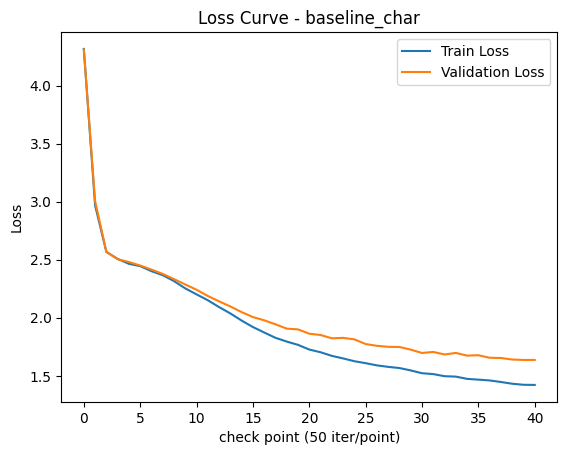

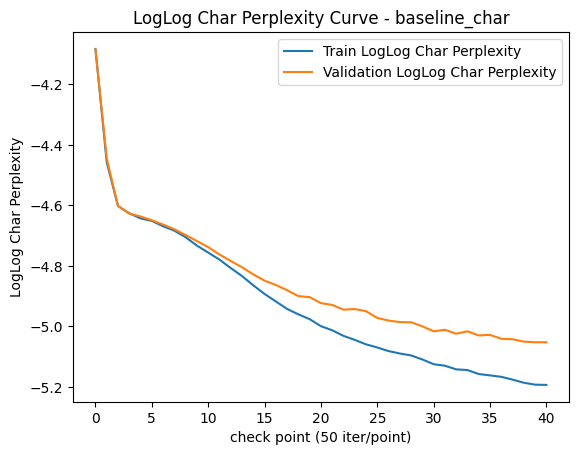

In [ ]:
plot_loss(baseline, "baseline_char")

In [ ]:
baselineTransoformer.to('cpu')
torch.cuda.empty_cache()

# Baseline - SimpleWord Tokenizer

In [ ]:
wordTokenizer = SimpleWordTokenizer(data)
baselineTransoformer = TransformerLM(wordTokenizer.vocab_size, CONTEXT_WINDOW_SIZE).to(device)
baseline_word = ModelTokenizerSystem(baselineTransoformer, wordTokenizer, device, model_name= "baseline_word", optimizer_weight_decay=0)

In [ ]:
baseline_word.train()

  0%|          | 1/2000 [00:07<4:06:12,  7.39s/it]

iteration 0
step 0: train loss 9.4171, val loss 9.4267


 10%|█         | 202/2000 [00:58<49:18,  1.65s/it]  

iteration 200
step 200: train loss 3.5387, val loss 3.6810


 20%|██        | 402/2000 [01:50<43:49,  1.65s/it]  

iteration 400
step 400: train loss 3.3664, val loss 3.5441


 22%|██▎       | 450/2000 [02:02<07:02,  3.66it/s]

Early Stopping Triggered at iteration 450


In [ ]:
baseline_word.save_model_data()

Model saved to baseline_word/model.pth
Training data saved to baseline_word/training_data.json


In [ ]:
print(baseline_word.generate(input_text1))


First Citizen:
Care for us! True, indeed! They ne'er cared for us
yet: suffer us to famish, and their store-houses
crammed with grain; make edicts for usury, to
support usurers; repeal daily any wholesome act
established against the rich, and provide more
piercing statutes daily, to chain up and restrain
the poor. If the wars eat us not up, they will; and
there's all the love they bear us.
And abundance.

Talk is not the I differs on right from against remain might no advanced;
And orders to breathe your given mercy:
Look ruetough me good with Minerva sick.

QUEEN iyou mistress decree, 
All
snatches' grant farewell, discolour' your conscience thus
TYRREL: here of brother path you let'd's found like hence.

Provost:
In pity Volsce' Richard had indeed.

rashness attendant please what earth.

DUKE go mighty;
See,
Appear time.sir.

BUCKINGHAM:
Why pith would Casting ; them thy that unlawful sir! ensues
Here'raw RICHARD so OF your invention,
If like ruin, him bear, dam:
Was set of will nig

In [ ]:
print(baseline_word.generate(input_text2))

MIRANDA:
Why speaks my father so ungently? This
Is the third man that e'er I saw, the first
That e'er I sigh'd for: pity move my father
To be inclined my way!

FERDINAND:
O, if a virgin,
And your affection not gone forth, I'll make you
The queen of Naples.
Of wind EDWARD mansion brands lives sides living these rough poor in Margaret,
Here air! thou than of to think-
You so reconcile father,
God the once of thou glittering one,
To in Montagues, my one do see index one the what make to barren the our
our Heat the deserve with spices,
Hath labour stock employ'd banish'let pity.Third for in from phoenix,
He?

chinks
Which of and true gods?appellant other to go,
fan's for mother of her toSuch:
Were lozel, York men,
monarchize: silver is to it do a fair,
Who; you will not me so moved of stay--HASTINGS:
Bad woe, banishment of were i's likely,
eye, here thy 


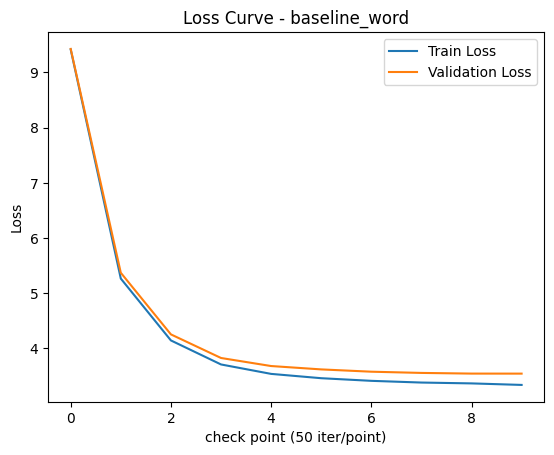

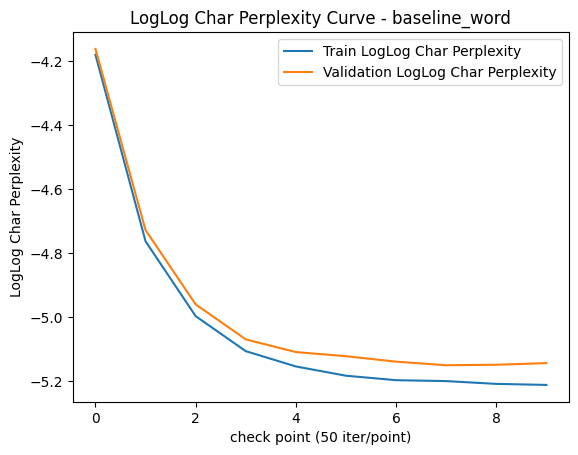

In [ ]:
plot_loss(baseline_word, "baseline_word")

In [ ]:
baselineTransoformer.to('cpu')
torch.cuda.empty_cache()

# Baseline - BPE Tokenizer

In [ ]:
bpeTokenizer = BPETokenizer(data)
baselineTransoformer = TransformerLM(bpeTokenizer.vocab_size, CONTEXT_WINDOW_SIZE).to(device)
baseline_bpe = ModelTokenizerSystem(baselineTransoformer, bpeTokenizer, device, model_name= "baseline_bpe", optimizer_weight_decay=0)

In [ ]:
baseline_bpe.train()

  0%|          | 1/2000 [00:06<3:43:03,  6.69s/it]

iteration 0
step 0: train loss 8.0314, val loss 8.0248


 10%|█         | 202/2000 [00:52<32:28,  1.08s/it]

iteration 200
step 200: train loss 5.2419, val loss 5.2655


 20%|██        | 402/2000 [01:38<28:54,  1.09s/it]

iteration 400
step 400: train loss 4.7784, val loss 4.9176


 30%|███       | 602/2000 [02:24<25:17,  1.09s/it]

iteration 600
step 600: train loss 4.5486, val loss 4.7735


 40%|████      | 802/2000 [03:10<21:39,  1.08s/it]

iteration 800
step 800: train loss 4.3235, val loss 4.6283


 50%|█████     | 1002/2000 [03:56<18:01,  1.08s/it]

iteration 1000
step 1000: train loss 4.1471, val loss 4.5308


 60%|██████    | 1202/2000 [04:41<14:25,  1.09s/it]

iteration 1200
step 1200: train loss 3.9654, val loss 4.4463


 70%|███████   | 1401/2000 [05:27<10:50,  1.09s/it]

iteration 1400
step 1400: train loss 3.7958, val loss 4.4066


 80%|████████  | 1601/2000 [06:13<07:12,  1.08s/it]

iteration 1600
step 1600: train loss 3.6272, val loss 4.3647


 90%|█████████ | 1802/2000 [06:59<03:34,  1.08s/it]

iteration 1800
step 1800: train loss 3.4545, val loss 4.3621


 95%|█████████▌| 1900/2000 [07:22<00:23,  4.30it/s]

Early Stopping Triggered at iteration 1900


In [ ]:
baseline_bpe.save_model_data()

Model saved to baseline_bpe/model.pth
Training data saved to baseline_bpe/training_data.json


In [ ]:
print(baseline_bpe.generate(input_text1))


First Citizen:
Care for us! True, indeed! They ne'er cared for us
yet: suffer us to famish, and their store-houses
crammed with grain; make edicts for usury, to
support usurers; repeal daily any wholesome act
established against the rich, and provide more
piercing statutes daily, to chain up and restrain
the poor. If the wars eat us not up, they will; and
there's all the love they bear us.

MENENIUS:
I cannot do rea gods
Let's blaster; friends, and since provility must
mersond by the very curt.

Shepherd:
There shall buy more together unknown it, indeed help of
a appear, and therefore my say shepherd to thought I
and money in Rome.

Shepherd:
Not a little more enough Lord Angelo where it died from
that he shall conceive her honour now better think it
Nor I would wreatersack him: yeaciet it is a plates; and
lpret things to raintenians, as thou desb all
trick, as much trial: bastards ready, secret intel
change thought it offitioned by the home, but displow with
vily; thee that cent of m

In [ ]:
print(baseline_bpe.generate(input_text2))

MIRANDA:
Why speaks my father so ungently? This
Is the third man that e'er I saw, the first
That e'er I sigh'd for: pity move my father
To be inclined my way!

FERDINAND:
O, if a virgin,
And your affection not gone forth, I'll make you
The queen of Naples.

LEONTES:
Cile:
MLIA: he have seen,
On andLARTIUS:
Homes, mourn in the swords of those hopes
What 'Who in peace in the reclinbleful heart
That waving your begg'd upon your abor,
Should not so visit'd with him?'d not dead.

Long morn,Becomor:
No, drinkabps, peace! but thou treason
Under the second sea and pominious trist
And the sickness of my desperate shame, or choice
No hopiber, glides no without person,
And drown'draw your death slain!

Gra sppes side:
The floop'dices wings here, these good friar;
And, though she finds with hate's king;
She may beaten avoily windy. My bosoms,
OrYC upon the prettemptling fury:
They on the wapens when the hiders hunts no sin!
That brafter the wall let'd be mild yourself,
And severer'd at the one wit

In [82]:
plot_loss(baseline_bpe, "baseline_bpe")

NameError: name 'baseline_bpe' is not defined

In [ ]:
baselineTransoformer.to('cpu')
torch.cuda.empty_cache()

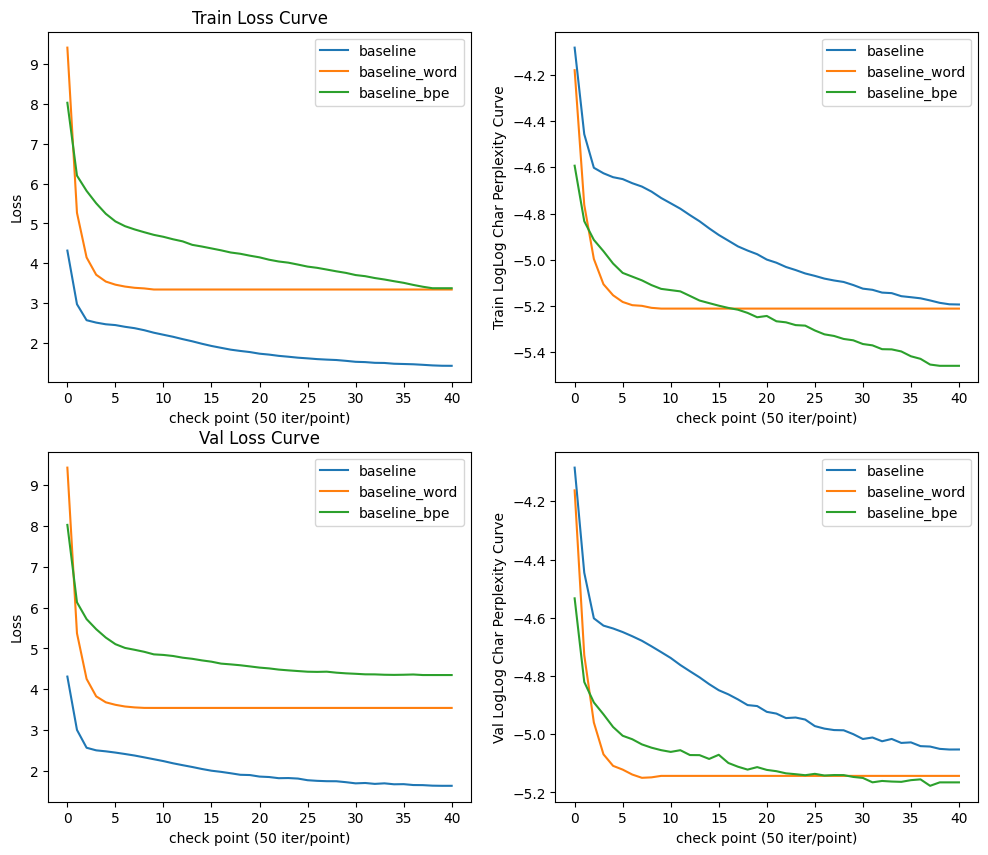

In [ ]:
baseline_list = [baseline, baseline_word, baseline_bpe]
model_name_list = ["baseline", "baseline_word", "baseline_bpe"]
model_compare_plots(baseline_list, model_name_list)

# Applying Rotary Position Embeddings

Char Tokenizer

In [95]:
charTokenizer = CharacterTokenizer(data)
baselineTransoformer_roe = TransformerLM(charTokenizer.vocab_size, CONTEXT_WINDOW_SIZE, roe = True).to(device)
char_baseline_roe = ModelTokenizerSystem(baselineTransoformer_roe, charTokenizer, device, model_name= "char_baseline_roe", optimizer_weight_decay=0)

In [96]:
char_baseline_roe.train()
char_baseline_roe.save_model_data()

  0%|          | 3/2000 [00:04<36:00,  1.08s/it]  

iteration 0
step 0: train loss 4.1761, val loss 4.1778


 10%|█         | 203/2000 [00:31<14:01,  2.14it/s]

iteration 200
step 200: train loss 1.9042, val loss 1.9846


 20%|██        | 403/2000 [00:57<12:27,  2.14it/s]

iteration 400
step 400: train loss 1.5925, val loss 1.7582


 30%|███       | 603/2000 [01:24<10:53,  2.14it/s]

iteration 600
step 600: train loss 1.4565, val loss 1.6569


 40%|████      | 803/2000 [01:51<09:20,  2.14it/s]

iteration 800
step 800: train loss 1.3822, val loss 1.5825


 50%|█████     | 1003/2000 [02:18<07:47,  2.13it/s]

iteration 1000
step 1000: train loss 1.3292, val loss 1.5417


 55%|█████▌    | 1100/2000 [02:31<02:04,  7.25it/s]

Early Stopping Triggered at iteration 1100
Model saved to char_baseline_roe_RoE/model.pth
Training data saved to char_baseline_roe_RoE/char_baseline_roe.json


In [97]:
print(char_baseline_roe.generate(input_text1))


First Citizen:
Care for us! True, indeed! They ne'er cared for us
yet: suffer us to famish, and their store-houses
crammed with grain; make edicts for usury, to
support usurers; repeal daily any wholesome act
established against the rich, and provide more
piercing statutes daily, to chain up and restrain
the poor. If the wars eat us not up, they will; and
there's all the love they bear us.
And all unmerry presented with me
Or down their borbs of crown take in as
Which ears to my soldiers strakes then,
To all I hope-pick deputy here breed.
O, Tybrave for the king. The sorrow comfor,
Richose still becaste, and Warwick is a swear thy
nowledges 


In [98]:
print(char_baseline_roe.generate(input_text2))

MIRANDA:
Why speaks my father so ungently? This
Is the third man that e'er I saw, the first
That e'er I sigh'd for: pity move my father
To be inclined my way!

FERDINAND:
O, if a virgin,
And your affection not gone forth, I'll make you
The queen of Naples.
Then is thy bander is crowned of's;
And here I swoad Oxfect fortunes, wwords: But I
fair barm in those holy honour's him?

ESCALURENCE:
In two accome of Hembridghose thorning air.

KING RICHARD IIII:
Good say angue.
Amen, yourself go tranish'd, or so, and 


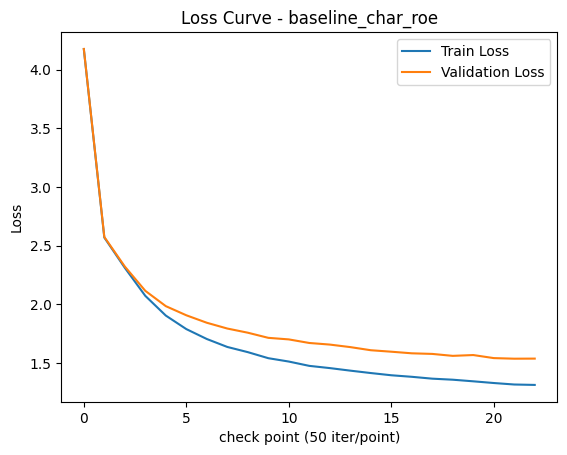

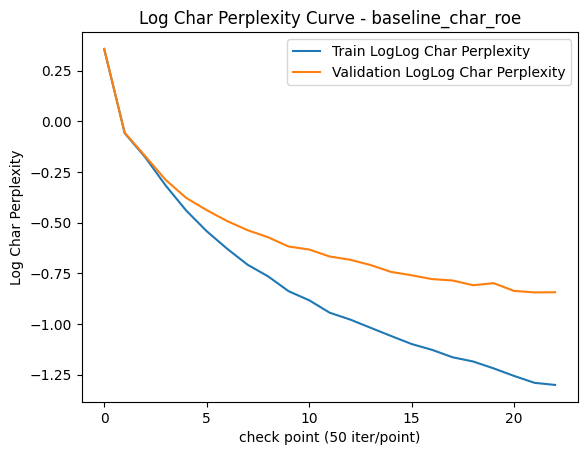

In [99]:
plot_loss(char_baseline_roe, "baseline_char_roe")

In [42]:
baselineTransoformer_roe.to('cpu')
torch.cuda.empty_cache()

----------------------------

Word Tokenizer

In [ ]:
wordTokenizer = SimpleWordTokenizer(data)
baselineTransoformer_roe = TransformerLM(wordTokenizer.vocab_size, CONTEXT_WINDOW_SIZE, roe = True).to(device)
word_baseline_roe = ModelTokenizerSystem(baselineTransoformer_roe, wordTokenizer, device, model_name= "word_baseline_roe", optimizer_weight_decay=0)

In [ ]:
word_baseline_roe.train()
word_baseline_roe.save_model_data()

In [ ]:
print(word_baseline_roe.generate(input_text1))

In [ ]:
print(word_baseline_roe.generate(input_text2))

In [ ]:
plot_loss(word_baseline_roe, "baseline_word_roe")

In [ ]:
baselineTransoformer_roe.to('cpu')
torch.cuda.empty_cache()

---------------------------------------------------------------

BPE Tokenizer

In [ ]:
bpeTokenizer = BPETokenizer(data)
baselineTransoformer_roe = TransformerLM(bpeTokenizer.vocab_size, CONTEXT_WINDOW_SIZE, roe = True).to(device)
bpe_baseline_roe = ModelTokenizerSystem(baselineTransoformer_roe, bpeTokenizer, device, model_name= "bpe_baseline_roe", optimizer_weight_decay=0)

In [ ]:
bpe_baseline_roe.train()
bpe_baseline_roe.save_model_data()

In [ ]:
print(bpe_baseline_roe.generate(input_text1))

In [ ]:
print(bpe_baseline_roe.generate(input_text2))

In [ ]:
plot_loss(bpe_baseline_roe, "baseline_bpe_roe")

In [ ]:
baselineTransoformer_roe.to('cpu')
torch.cuda.empty_cache()

------------------------------------------

In [ ]:
baseline_list_roe = [char_baseline_roe, word_baseline_roe, bpe_baseline_roe]
model_name_list_roe = ["char_baseline_roe", "baseline_word_roe", "baseline_bpe_roe"]
model_compare_plots(baseline_list_roe, model_name_list_roe)

# Applying Reg & Gelu

Char Tokenizer

In [43]:
charTokenizer = CharacterTokenizer(data)
baselineTransoformer_regelu = TransformerLM(charTokenizer.vocab_size, CONTEXT_WINDOW_SIZE, gelu= True, dropout=True, rmsnorm=True).to(device)
char_baseline_regelu = ModelTokenizerSystem(baselineTransoformer_regelu, charTokenizer, device, model_name= "char_baseline_regelu")

In [44]:
char_baseline_regelu.train()
char_baseline_regelu.save_model_data()

  0%|          | 1/2000 [00:06<3:39:40,  6.59s/it]

iteration 0
step 0: train loss 4.1421, val loss 4.1518


 10%|█         | 201/2000 [00:51<31:44,  1.06s/it]

iteration 200
step 200: train loss 2.5232, val loss 2.5234


 20%|██        | 402/2000 [01:37<28:15,  1.06s/it]

iteration 400
step 400: train loss 2.4348, val loss 2.4419


 30%|███       | 601/2000 [02:22<24:41,  1.06s/it]

iteration 600
step 600: train loss 2.2756, val loss 2.2982


 40%|████      | 801/2000 [03:07<21:09,  1.06s/it]

iteration 800
step 800: train loss 2.1325, val loss 2.1824


 50%|█████     | 1002/2000 [03:53<17:36,  1.06s/it]

iteration 1000
step 1000: train loss 2.0096, val loss 2.0819


 60%|██████    | 1201/2000 [04:38<14:05,  1.06s/it]

iteration 1200
step 1200: train loss 1.8971, val loss 1.9975


 70%|███████   | 1401/2000 [05:23<10:34,  1.06s/it]

iteration 1400
step 1400: train loss 1.8172, val loss 1.9442


 80%|████████  | 1602/2000 [06:08<05:53,  1.12it/s]

iteration 1600
step 1600: train loss 1.7478, val loss 1.9182


 90%|█████████ | 1802/2000 [06:54<03:29,  1.06s/it]

iteration 1800
step 1800: train loss 1.6761, val loss 1.8508


100%|██████████| 2000/2000 [07:39<00:00,  4.35it/s]

iteration 1999
step 1999: train loss 1.6306, val loss 1.8120
Model saved to char_baseline_regelu_RMSNorm_GELU_Dropout_wd0.1/model.pth
Training data saved to char_baseline_regelu_RMSNorm_GELU_Dropout_wd0.1/char_baseline_regelu.json


In [45]:
print(char_baseline_regelu.generate(input_text1))


First Citizen:
Care for us! True, indeed! They ne'er cared for us
yet: suffer us to famish, and their store-houses
crammed with grain; make edicts for usury, to
support usurers; repeal daily any wholesome act
established against the rich, and provide more
piercing statutes daily, to chain up and restrain
the poor. If the wars eat us not up, they will; and
there's all the love they bear us.
This Gaus kings, not good the, and tattir, on
fell or'' some!

Ston's your offives that mornO, in mode reman?

Shek Secour Wear. 3

KING EDING RI:
Nay, no lE.'

AUTOMERHAS:
Owar! God Gracious, I, ver or depy;
Nur'ser with nat's are lherd, apisired!


DUCHE


In [46]:
print(char_baseline_regelu.generate(input_text2))

MIRANDA:
Why speaks my father so ungently? This
Is the third man that e'er I saw, the first
That e'er I sigh'd for: pity move my father
To be inclined my way!

FERDINAND:
O, if a virgin,
And your affection not gone forth, I'll make you
The queen of Naples.


SAMWID:
O kepenle you father's hand!

EDY ZANGUM:
How seephr:
You should live your earsunt and rest
Her souman, will the bedger, and bong
Yy lords to bean bring hiyd not have everl, an.

WARWICK:
Till  reaturey;
The sray death, the our priences muter fri


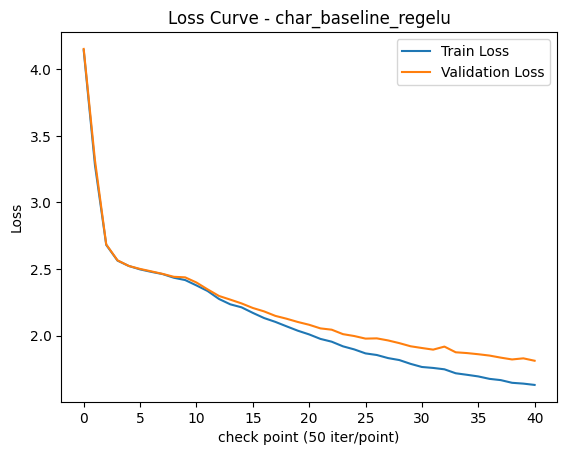

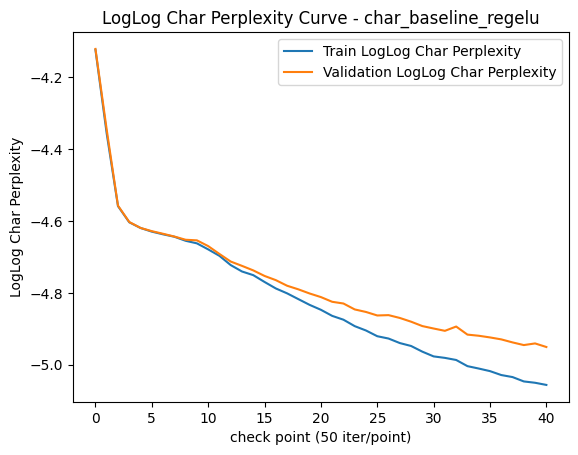

In [47]:
plot_loss(char_baseline_regelu, "char_baseline_regelu")

In [48]:
baselineTransoformer_regelu.to('cpu')
torch.cuda.empty_cache()

-------------------------------------------------------

Word Tokenizer

In [ ]:
wordTokenizer = SimpleWordTokenizer(data)
baselineTransoformer_regelu = TransformerLM(charTokenizer.vocab_size, CONTEXT_WINDOW_SIZE, gelu= True, dropout=True, rmsnorm=True).to(device)
word_baseline_regelu = ModelTokenizerSystem(baselineTransoformer_regelu, wordTokenizer, device, model_name= "word_baseline_regelu")

In [ ]:
word_baseline_regelu.train()
word_baseline_regelu.save_model_data()

In [ ]:
print(word_baseline_regelu.generate(input_text1))

In [ ]:
print(word_baseline_regelu.generate(input_text2))

In [ ]:
plot_loss(word_baseline_regelu, "word_baseline_regelu")

In [ ]:
baselineTransoformer_regelu.to('cpu')
torch.cuda.empty_cache()

---------------------------------------------------------------------

BPE Tokenizer

In [ ]:
bpeTokenizer = BPETokenizer(data)
baselineTransoformer_regelu = TransformerLM(charTokenizer.vocab_size, CONTEXT_WINDOW_SIZE, gelu= True, dropout=True, rmsnorm=True).to(device)
bpe_baseline_regelu = ModelTokenizerSystem(baselineTransoformer_regelu, bpeTokenizer, device, model_name= "bpe_baseline_regelu")

In [ ]:
bpe_baseline_regelu.train()
bpe_baseline_regelu.save_model_data()

In [ ]:
print(bpe_baseline_regelu.generate(input_text1))

In [ ]:
print(bpe_baseline_regelu.generate(input_text2))

In [ ]:
plot_loss(bpe_baseline_regelu, "bpe_baseline_regelu")

In [ ]:
baselineTransoformer_regelu.to('cpu')
torch.cuda.empty_cache()

---------------------------------------------------------

In [ ]:
baseline_list_regelu = [char_baseline_regelu, word_baseline_regelu, bpe_baseline_regelu]
model_name_list_regelu = ["char_baseline_regelu", "word_baseline_regelu", "bpe_baseline_regelu"]
model_compare_plots(baseline_list_regelu, model_name_list_regelu)

# Full Models - Reg & GELU & RPoE

Char Tokenizer

In [49]:
charTokenizer = CharacterTokenizer(data)
FullTransoformer = TransformerLM(charTokenizer.vocab_size, CONTEXT_WINDOW_SIZE, gelu= True, dropout=True, rmsnorm=True, roe= True).to(device)
char_full = ModelTokenizerSystem(FullTransoformer, charTokenizer, device, model_name= "char_full")

In [50]:
char_full.train()
char_full.save_model_data()

  0%|          | 3/2000 [00:04<36:33,  1.10s/it]  

iteration 0
step 0: train loss 4.2460, val loss 4.2483


 10%|█         | 203/2000 [00:32<14:18,  2.09it/s]

iteration 200
step 200: train loss 2.1998, val loss 2.2181


 20%|██        | 403/2000 [00:59<12:43,  2.09it/s]

iteration 400
step 400: train loss 1.9174, val loss 1.9986


 30%|███       | 603/2000 [01:27<11:07,  2.09it/s]

iteration 600
step 600: train loss 1.7527, val loss 1.8755


 40%|████      | 803/2000 [01:55<09:32,  2.09it/s]

iteration 800
step 800: train loss 1.6352, val loss 1.7829


 50%|█████     | 1003/2000 [02:23<07:56,  2.09it/s]

iteration 1000
step 1000: train loss 1.5559, val loss 1.7376


 60%|██████    | 1203/2000 [02:51<06:20,  2.09it/s]

iteration 1200
step 1200: train loss 1.4997, val loss 1.6864


 70%|███████   | 1403/2000 [03:19<04:45,  2.09it/s]

iteration 1400
step 1400: train loss 1.4580, val loss 1.6631


 78%|███████▊  | 1550/2000 [03:39<01:03,  7.05it/s]

Early Stopping Triggered at iteration 1550
Model saved to char_full_RoE_RMSNorm_GELU_Dropout_wd0.1/model.pth
Training data saved to char_full_RoE_RMSNorm_GELU_Dropout_wd0.1/char_full.json


In [51]:
print(char_full.generate(input_text1))


First Citizen:
Care for us! True, indeed! They ne'er cared for us
yet: suffer us to famish, and their store-houses
crammed with grain; make edicts for usury, to
support usurers; repeal daily any wholesome act
established against the rich, and provide more
piercing statutes daily, to chain up and restrain
the poor. If the wars eat us not up, they will; and
there's all the love they bear us.

I him I doubtle and, sue! Gods day son, thy figh him,
Wont bear the stip say' traitor'dy with turge,
In he queen not los insuly theb my po't.
It in your sehold to this heard. GenProuge, yet littor?
But took you are look'd love to hind in's.

FLORIZEL:
Nou


In [52]:
print(char_full.generate(input_text2))

MIRANDA:
Why speaks my father so ungently? This
Is the third man that e'er I saw, the first
That e'er I sigh'd for: pity move my father
To be inclined my way!

FERDINAND:
O, if a virgin,
And your affection not gone forth, I'll make you
The queen of Naples.
Surceingby; of jointermembe he 'ender'd,
For hany in O, trib rounly sayst
You here ipal be; hi do him, as a king so.
I, seeply thou on'n, shall these had do;
Boy bidy had that your pierful subject,
And yet myself he appeased, mest gome goods.

CORIOLANUS:



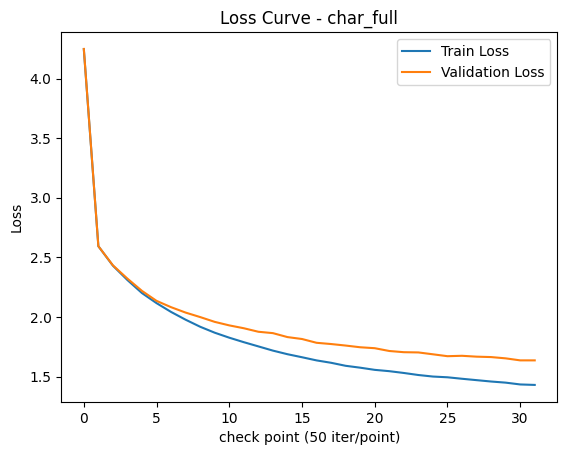

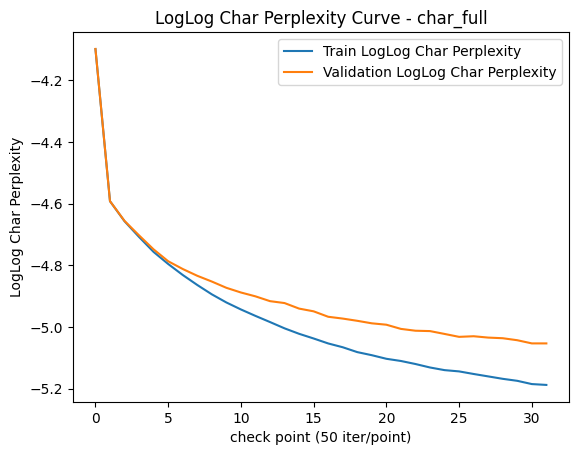

In [53]:
plot_loss(char_full, "char_full")

In [54]:
baselineTransoformer_regelu.to('cpu')
torch.cuda.empty_cache()

------------------------------------------------------------------

Word Tokenizer

In [ ]:
wordTokenizer = SimpleWordTokenizer(data)
FullTransoformer = TransformerLM(wordTokenizer.vocab_size, CONTEXT_WINDOW_SIZE, gelu= True, dropout=True, rmsnorm=True, roe= True).to(device)
word_full = ModelTokenizerSystem(FullTransoformer, wordTokenizer, device, model_name= "word_full")

In [ ]:
word_full.train()
word_full.save_model_data()

In [ ]:
print(word_full.generate(input_text1))

In [ ]:
print(word_full.generate(input_text2))

In [ ]:
plot_loss(word_full, "word_full")

In [ ]:
baselineTransoformer_regelu.to('cpu')
torch.cuda.empty_cache()

------------------------------------------------------------------

BPE Tokenizer

In [ ]:
bpeTokenizer = BPETokenizer(data)
FullTransoformer = TransformerLM(bpeTokenizer.vocab_size, CONTEXT_WINDOW_SIZE, gelu= True, dropout=True, rmsnorm=True, roe= True).to(device)
bpe_full = ModelTokenizerSystem(FullTransoformer, bpeTokenizer, device, model_name= "bpe_full")

In [ ]:
bpe_full.train()
bpe_full.save_model_data()

In [ ]:
print(bpe_full.generate(input_text1))

In [ ]:
print(bpe_full.generate(input_text2))

In [ ]:
plot_loss(bpe_full, "bpe_full")

In [ ]:
baselineTransoformer_regelu.to('cpu')
torch.cuda.empty_cache()

--------------------------------------------------------------------------------

In [ ]:
full_list = [char_full, word_full, bpe_full]
model_name_list_full = ["char_full", "word_full", "bpe_full"]
model_compare_plots(full_list, model_name_list_full)

# Tokenizer & [Baseline, Baseline_roe, Baseline_regule, Full] Compare

### Char Tokenizer

<ipython-input-88-ddb0bb982ea9>:26: RuntimeWarning: invalid value encountered in log
  axes[axis_x, axis_y].plot(np.log(np.log(np.log(model_system.char_perplexities_train_val[name]))), label= model_name)


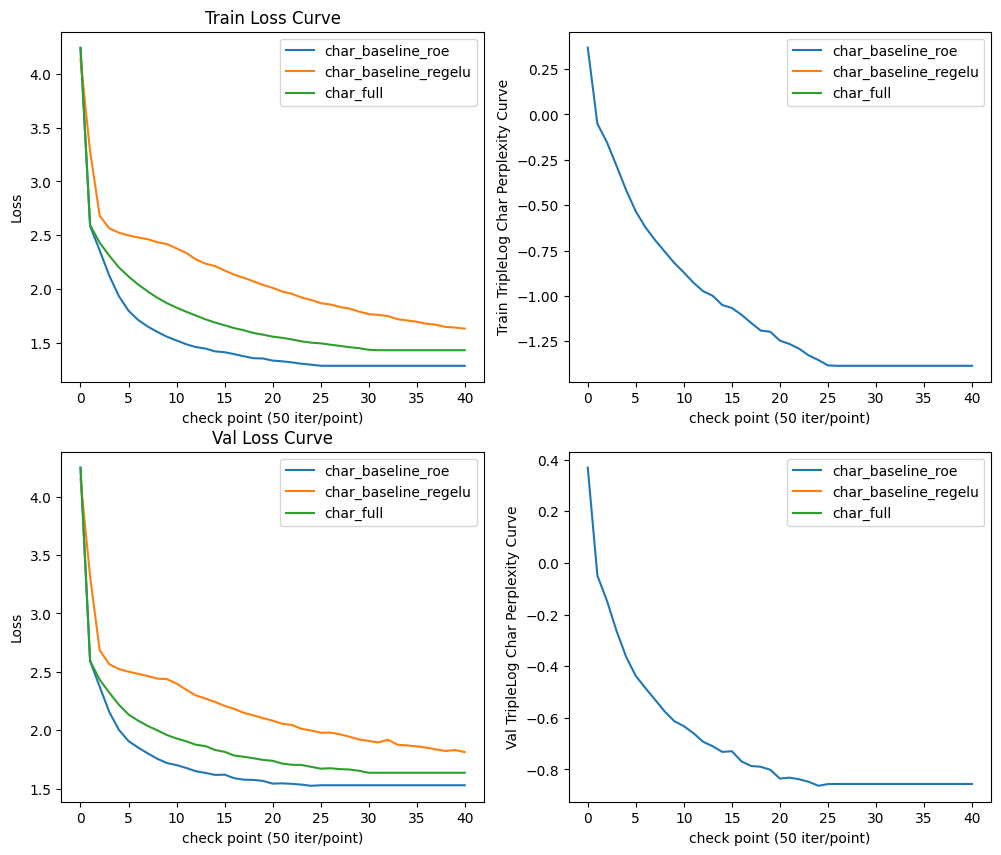

In [91]:
char_list = [char_baseline_roe, char_baseline_regelu, char_full]
model_name_list_char = ["char_baseline_roe", "char_baseline_regelu", "char_full"]
model_compare_plots(char_list, model_name_list_char)

### Word Tokenizer

In [ ]:
word_list = [baseline_word, word_baseline_roe, word_baseline_regelu, word_full]
model_name_list_word = ["baseline_word", "word_baseline_roe", "word_baseline_regelu", "word_full"]
model_compare_plots(word_list, model_name_list_word)

### BPE Tokenizer

In [ ]:
bpe_list = [baseline_bpe, bpe_baseline_roe, bpe_baseline_regelu, bpe_full]
model_name_list_bpe = ["baseline_bpe", "bpe_baseline_roe", "bpe_baseline_regelu", "bpe_full"]
model_compare_plots(bpe_list, model_name_list_bpe)

### Baseline (Char Tokenizer) vs Full (Char, Word, BPE)

In [ ]:
final_list = [baseline, char_full, word_full, bpe_full]
model_name_list_final = ["baseline", "char_full", "word_full", "bpe_full"]
model_compare_plots(final_list, model_name_list_final)